In [1]:
# In this project, I tried to back-test a trading strategy using the Euro-Dollar 3 months future index.
# The long-short signals is based on the moving average price and the volatility regime is predicted by GARCH model.
# The strategy can obtain a 0.97 Sharpe ratio for optimize parametters and 0.77 for out-of-sample Walk Forward Analysis.
# I also test this strategy with S&P 500 e-Mini future index and it obtains 0.71 for Sharpe ratio
# This strategy is based on paper 'Quantitative Investment Strategies Research: Investing in Central Bank Momentum'
# of Morgan Stanley Research

C:\Users\18183432\OneDrive - LA TROBE UNIVERSITY\Python\trading strategy\aws\Walk_forward_testing


In [ ]:
import os
# os.chdir('C:\\Users\\18183432\\OneDrive - LA TROBE UNIVERSITY\\Python\\trading strategy\\aws\\Walk_forward_testing') 
cwd = os.getcwd()
print(cwd)
import pandas as pd
import numpy as np
import scipy.optimize as sco

#from itertools import product
#import functools

# matplotlib for plotting
import matplotlib.pyplot as plt

# GARCH model for estimation
from arch import arch_model

In [113]:
def drawdown (final):
    '''
    function to calculate drawdown of security/portfolio
    
    Input:
        final: return serires of security/portfolio
    Output:
        drawdown of portfolio
    '''
    cum_rets = (1 + final).cumprod()
    drawdown =  -(1-cum_rets.div(cum_rets.cummax()))
     
    return drawdown

def future_analyzing_contract(price,window = 252*3, MA1 = 66, MA2=262, forecast_horizon = 1, agg ='mean', update_regime = 5): # compare the median of forecast volatility last three year with the forecast volatility tomorrow to decide the volatility regime
    '''
    This function is to calculate the return of a future constract with a trading strategy based of volatility regime and moving average price of 66 days
    (for low volatility regime) and 252 days (for high volatility regime)
    
    Input
    -----
        Price: a data frame with a Time column and Price column
        window: number of days to fit GARCH(1,1)
        forecast_horizon: horizon to forecast volatility regime
        update_regime: the frequency of regime update
        
    Output
    ------
        price_minus_window: a dataframe with 10 columns including Time,price, log_ret,low66, high252, forecasted _variance, realized_vars, median_variance, regime, ret
        annualized_returns
        annualized_sharpe
        annualized_standard_deviation
        proportion_long_over_short
        max_draw_down
    
    '''
    price.columns =['Time', 'price'] # Reset the name of colums
    price['Time'] = pd.to_datetime(price['Time'], format=('%m/%d/%Y')) # Convert the time column to time object
    price.dropna(axis = 0, inplace = True) # Eliminate NA values
    #price.shape

    ### 1. Calculate the return of contract
    #price['log_ret'] = np.log(price.price.astype(float)) - np.log(price.price.shift(1).astype(float)) # W e may use: price['ret_ptc']= price['price'].pct_change(1)
    price['log_ret'] =  price['price'].astype(float).pct_change()*100
    #price['log_ret'] = ((price.price.astype(float) - price.price.shift(1).astype(float))/ price.price.shift(1).astype(float))*100
    # price['log_ret'] = np.log(price.price.astype(float)/price.price.shift(1).astype(float))
    price = price.reset_index().drop(columns =['index'])
    ### 2. Create the moving averange price with window = 66 days for low volatility regime and window = 252 days for hig volatility regime    
    price['low66'] = price['price'].rolling(MA1).mean() # 66
    price['high252'] = price['price'].rolling(MA2).mean() #252
    #price
    ### 3.Calculate GARCH volatility with 3 years window (=3*252 days)
    ret = np.array(price['log_ret'].dropna())
    predictions =[]
    realized_vars =[]
    price_minus_window = price.iloc[window:,:].reset_index().drop(columns = ['index'])
    # price_minus_window = price_minus_window.reset_index().drop(columns = ['index'])
    for i in range(len(ret)-window+1): # i = 1
        ret1 = np.array(ret[i:i+window])# len(ret1)
        # Record realized variance for comparison with forecast values
        realized_var = np.var(ret1)
        realized_vars.append(realized_var)
        # set up GARCH model
        model = arch_model(ret1, mean='Zero', vol='GARCH', p=1, q=1)#
        # fit model
        model_fit = model.fit()
        
        # Record forecast values of Variance
        prediction = model_fit.forecast(horizon=forecast_horizon).variance.values[-1]
        predictions.append(np.mean(prediction))
# =============================================================================
#         if agg == 'median':
#             predictions.append(np.median(prediction))
#         elif agg == 'min':
#             predictions.append(np.min(prediction))
#         elif agg == 'max':
#             predictions.append(np.max(prediction))
#         else:
#             predictions.append(np.mean(prediction))
# =============================================================================

    # put the variance and relized variance into data frame   
    price_minus_window ['forecasted_variance'] = np.array(predictions, float) 
    price_minus_window ['realized_vars'] = realized_vars
    # calculate the median of rolling-3-year window variance
    price_minus_window['median_forecast_variance'] = price_minus_window['forecasted_variance'].rolling(window).median()
    # eleminate NA values
    price_minus_window = price_minus_window.dropna().reset_index().drop(columns = ['index'])
    # plot the actual variance and forecast variance for comparison
    var = price_minus_window ['realized_vars'] 
    forecast_variance = price_minus_window ['forecasted_variance']
# =============================================================================
#     plt.plot(var,'r-', label = 'realized')
#     plt.plot(forecast_variance,'b-',label = 'forecast')
#     plt.legend()
#     plt.title('Realized volatility and Forecast volatility from GARCH(1,1)')
#     plt.show()
# =============================================================================
    price_minus_window1 = price_minus_window.copy()
    price_minus_window =   price_minus_window1.copy()  
    price_minus_window1.head()
    ### 4.Create a column to indicate volatility regime
    regime = []
    #update_regime = 5 # as the paper said that they only update regime 1 time a week, then update_regime is set by 5 business days.
    for i in range(update_regime, price_minus_window.shape[0], update_regime): # i = 5, i = 5 +5
        #print(i)
        if price_minus_window['forecasted_variance'][i] > price_minus_window['median_forecast_variance'][i-1]:
            regime += ['low']* update_regime
        else:
            regime += ['high']*update_regime

    # Handle the remainder of (number of days / update-regime)
    if price_minus_window['forecasted_variance'].iloc[-1] > price_minus_window['median_forecast_variance'].iloc[-2]:
        if (price_minus_window.shape[0] % update_regime) == 0:
            regime += ['low']* update_regime
        else:
            regime += ['low']* (price_minus_window.shape[0] % update_regime)
    else:
        if (price_minus_window.shape[0] % update_regime) == 0:
            regime += ['high']* update_regime
        else:
            regime += ['high']* (price_minus_window.shape[0] % update_regime)
   # Put regime back into dataframe 
    price_minus_window['regime'] = regime
    
    # Check dataframe
    # price_minus_window.head()
    ### 5.1_Calculate return based on the volatility levels (regime) and moving average value of stock prices


# =============================================================================
#     ret = []
#     long_short =[]
#     for i in range (price_minus_window.shape[0]-1): #i = 1
#         if price_minus_window['regime'].iloc[i] == 'low': # Consider the low regime case
#             if float(price_minus_window['price'].iloc[i]) >= float(price_minus_window['low66'].iloc[i]): # if price > MA, then "short'
#                 ret.append(float(price_minus_window['log_ret'].iloc[i+1]))
#                 long_short.append('short')
#             else :
#                 ret.append(float(price_minus_window['log_ret'].iloc[i+1])*(-1)) # if price < MA, then "long'
#                 long_short.append('long')
#         else: # # Consider the high regime case
#             if float(price_minus_window['price'].iloc[i]) >= float(price_minus_window['high252'].iloc[i]) :
#                 ret.append(float(price_minus_window['log_ret'].iloc[i+1]))
#                 long_short.append('short')
#             else:
#                 ret.append(float(price_minus_window['log_ret'].iloc[i+1])*(-1))
#                 long_short.append('long')
#     ret.insert(0, 0) # insert return = 0 for the first day
#     long_short.insert(0, 'None')# insert long_short = None for the first day
#     price_minus_window['ret'] = ret
#     price_minus_window['long_short'] = long_short
#     price_minus_window.tail()
# =============================================================================

    ### 5.2_Calculate return based on the volatility levels (regime) and moving average value of stock prices
    price_minus_window['price'] = np.array(price_minus_window['price'], float)
    price_minus_window['low66'] = np.array(price_minus_window['low66'], float)
    price_minus_window['high252'] = np.array(price_minus_window['high252'], float)
    price_minus_window ['position'] = np.where(price_minus_window['regime'] =='low', np.where(price_minus_window['price'] >= price_minus_window['low66'],1, -1), np.where(price_minus_window['price'] >= price_minus_window['high252'],1, -1))
    price_minus_window ['ret'] = price_minus_window ['position'].shift(1)* price_minus_window ['log_ret']
 

    #### 6.Statistic information of future contract 

    # return
    price_minus_window['Cum_ret'] = (1+price_minus_window['ret']).cumprod() -1 
    avg_annualized_return = (1+price_minus_window['Cum_ret'].iloc[-1])**(252/price_minus_window.shape[0])-1
    
    # print('Average annualized daily return of contract is', avg_annualized_return,'%')
    # standard deviation
    annualized_standard_deviation = price_minus_window['ret'].std()*np.sqrt(252)
    # print('Annualized standard deviation return of contract is', annualized_standard_deviation, '%')
    # sharpe ratio
    annualized_sharpe = avg_annualized_return/annualized_standard_deviation
    # information ratio: need a benchmark to calculate information ratio, what we should use for benchmark
    # https://www.investopedia.com/terms/i/informationratio.asp
    
    # % of time long/% of time short
    if price_minus_window.loc[price_minus_window['position'] == -1].shape[0] ==0:
        proportion_long_over_short = 'Full Short'
    else:
        proportion_long_over_short = price_minus_window.loc[price_minus_window['position'] == 1].shape[0]/price_minus_window.loc[price_minus_window['position'] == -1].shape[0]
    # print('Proportion of Long days over Short day is',proportion_long_over_short)
    
    # Maximum draw down
    max_draw_down = max(-drawdown(price_minus_window['ret'].dropna()))
    #print('Maximum draw down of contract is', max_draw_down)
    
    # create a new subplot for each source
    # plt.hist(price_minus_window['ret'], bins='auto')
    # plt.title("Histogram of contract" + str(contract))
    # plt.xlabel("Return")
    # plt.ylabel('Frequency')
    # plt.savefig('histogram of contract'+str(contract)+'.png')
    
    return price_minus_window, avg_annualized_return, annualized_sharpe, annualized_standard_deviation,proportion_long_over_short, max_draw_down

def future_analyzing_port_baseline(data, MA1 = 5, MA2=210, window = 3,  forecast_horizon = 5, update_regime = 5): 
    '''
    This function will will create a trading strategy based of volatility regime and moving average price.
    First, it compare the median of forecast volatility last three year with the forecast volatility tomorrow to decide whether the volatility regime is high ow low
    if volatility regime is low, it will go long (buy) if price of STIR > moving average price of MA1 days and short if price of STIR < moving average price of MA1 days
    if volatility regime is high, it will go long (buy) if price of STIR > moving average price of MA1 days and short if price of STIR < moving average price of MA2 days
     
    Input
    -----
        data: a csv file cotaining columns. Each column provides price over time of 1 future contract
        window: number of years to fit GARCH(1,1), can be from 1-4, otherwise we can not have enough observations for strategy
        weight: for calcualting the portfolio return, can be 'max_sharpe', 'min_vol' or equal
        MA1: moving average window for low volatility regime
        MA2: moving average window for high volatility regime
        forecast_horizon: horizon to forecast volatility regime
        agg: the method to choose the calculate the volatility forecast if  forecast_horizon > 1, the method can be 'min', 'max', 'mean' and 'median'
        update_regime: the frequency of regime update
        
    Output
    ------
        port_ret: a dataframe which includes Time and return of each contract
        port_ret1: similar to port_ret but with Time column is convereted to index
        summary_port: a data frame containing avg_annualized_return, annualized_standard_deviation and annualized_Sharpe of portfolio
        summary_contracts: annualized_ret, annualized_sharpe, standard_deviations, max_draw_downs of individual contracts.
        weights: optimal weights of portfolio in 3 cases: 'max_shape', 'min_volatility' and 'equal_weight'
        annualized_Sharpe, max_draw_down_port: annualized_sharpe and max_draw_down of portfolio

    Time
    ------
        It took around 20 minutes to run this function for 'STIR_futures_sample.csv' in Phong's Laptop
    '''
    # Read data 
    df = data   # df = valid_set[2]
    # create the name for columns (the name of column is the number of investigated contract)
    col =['Time']
    for i in range(1, df.shape[1],1):
        col.append(str(i))
    df.columns = col # set the name for columns
    df['Time'] = pd.to_datetime(df['Time'], format=('%m/%d/%Y')) # Convert 'Time' column to Time object
    ### Find the valid contract that have number of observation bigger than required number of observations

    # Eliminate NA values
    valid_contracts=[] 
    n= 2# n= 2 if we use the median of forecast values from GARCH(1,1) as a bench macrh to choose volatility regime, and n = 1 if use the median of fitted values from GARCH(1,1)
    for i in range(1,df.shape[1],1): 
        col[i]= df[['Time',str(i)]].dropna() # Create dataframe for different contracts
        if col[i].shape[0]>(window+3)*252: 
            valid_contracts.append(str(i))
    valid_contracts

    ### Calculate return for each contract and put the dataframe results into a list called individual_ret
    # We will have 19 dataframes in this list in the case n = 2. I also calclute the annualized_ret, ann_sd, annualized_sharpe, long_short ratio and max_draw_downs for each contract
    individual_ret = []
    annualized_ret=[]
    annualized_sharpe =[]
    standard_deviations =[]
    proportion_long_over_shorts=[]
    max_draw_downs=[]
    long_short =[]
    for contract in valid_contracts: # contract = 43
        price = col[int(contract)].reset_index().drop(columns =['index'])
        price_minus_window, annualized_returns, a_sharpe, standard_deviation, proportion_long_over_short, max_draw_down = future_analyzing_contract(price,window = 252*window, MA1=MA1, MA2=MA2, forecast_horizon = forecast_horizon, agg ='mean', update_regime = update_regime)
        
        individual_ret.append(price_minus_window[['Time','ret']])
        
    ### Collect the returns columns of each contract and merger them tegether based on 'Time' columns
    port_ret =pd.DataFrame(individual_ret[0])  
    for i in range(1,len(individual_ret),1): # i = 1
        port_ret = port_ret.merge(pd.DataFrame(individual_ret[i]),on='Time', how='outer')

    ### Create the name for columns in port_ret dataframe 
    column1 = valid_contracts.copy()
    column1.insert(0,'Time')
    port_ret.columns = column1
    port_ret.fillna(0, inplace=True)
    port_ret1 = port_ret.set_index('Time')
    noa =len(valid_contracts)
    weight_port = np.array(noa*[1./noa,]) # Equal weights
    
# =============================================================================
#     # Calculate weight for portfolio 
#     def portfolio_ret(weights,port_ret = port_ret1):
#         return np.sum(port_ret.mean()*weights)*252
#     def portfolio_vol(weights,port_ret = port_ret1):
#         return np.sqrt(np.dot(weights.T,np.dot(port_ret.cov()*252,weights)))
#     def min_func_sharpe(weights): # function to be optimized
#         return -portfolio_ret(weights)/portfolio_vol(weights)
#     
#     cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}) # equality constrain sum(weights) =1
#     bnds = tuple((0,1) for x in range(noa)) # bound for individual weight
#     
#     ## Equal weight
#     
#     ## Optimal weight for maximizing Sharpe ratio
#     if weight == 'max_sharpe':  
#         opts =sco.minimize(min_func_sharpe,eweights, method ='SLSQP', bounds = bnds, constraints=cons)
#         weight_port = opts['x']
#     ## Optimal weight for minimizing the variance of the portfolio
#     if weight == 'min_vol': 
#         optv = sco.minimize(portfolio_vol,eweights, method ='SLSQP', bounds = bnds, constraints=cons)
#         weight_port = optv['x'] 
# =============================================================================
    # Calculate Total return for each contract and cummulative return
    
    port_ret['Total Ret'] = port_ret.drop(columns = 'Time').mul(weight_port,axis=1).sum(axis=1)
    port_ret1['Total Ret'] = np.array(port_ret['Total Ret'])
    port_ret['Cummulative return'] = (1+port_ret['Total Ret']).cumprod() -1 #.cumsum)()
    port_ret1['Cummulative return']= np.array(port_ret['Cummulative return'])
    winning_percentage = len(port_ret[port_ret['Total Ret']>0])/len(port_ret)
    
    # Plot the return of porfolio over time
# =============================================================================
#     import matplotlib.pyplot as plt
#     plt.style.use('fivethirtyeight')
# 
#     port_ret1['Cummulative return'].plot(figsize=(10,8))
#     plt.title('Cummulative return of portfolio '+ str(valid_contracts))
#     plt.show()
# =============================================================================

    avg_annualized_return_port = (1+port_ret['Cummulative return'].iloc[-1])**(252/port_ret1['Cummulative return'].shape[0])-1
    
    # standard deviation
    annualized_standard_deviation = port_ret1['Total Ret'].std()*np.sqrt(252)
    
    # sharpe ratio
    annualized_Sharpe = avg_annualized_return_port/annualized_standard_deviation
    
    max_draw_down_port = max(-drawdown(port_ret['Total Ret']))
    summary_port = pd.DataFrame({'Start':port_ret['Time'].iloc[0] ,'Finish':port_ret['Time'].iloc[-1],'MA1': MA1,'MA2': MA2,'annualized_return': avg_annualized_return_port, 'annualized_sd': annualized_standard_deviation,
                                 'annualized_Sharpe': annualized_Sharpe,'max_draw_down': max_draw_down_port, 'winning_percentage': winning_percentage }, index=[0])
    
    
    #weights = pd.DataFrame({'contract': valid_contracts, 'weights':weight_port})
    return port_ret # summary_port# 

In [ ]:
# Run Grid Search to find How MA1 and MA2 affect the Sharpe value
import itertools
ma1 = range(5, 70, 5) # ma1 =[5]
ma2 = range(21,252*2, 21) # ma2 =range(150,252, 5)
results = pd.DataFrame()
for MA1, MA2 in product(ma1,ma2): # MA1 = 5, MA2 = 63, wi =3
    port_ret, port_ret1, summary_port,summary_contracts, annualized_Sharpe, weights, max_draw_down_port = future_analyzing_port(data = 'STIR_futures_sample.csv',window = 3,weight = 'equal', MA1 = MA1, MA2=MA2, forecast_horizon = 6, update_regime = 5)
    results = results.append(summary_port)
results.sort_values('annualized_Sharpe', ascending = False).to_csv('grid_search.csv', index = False)

<IPython.core.display.Javascript object>


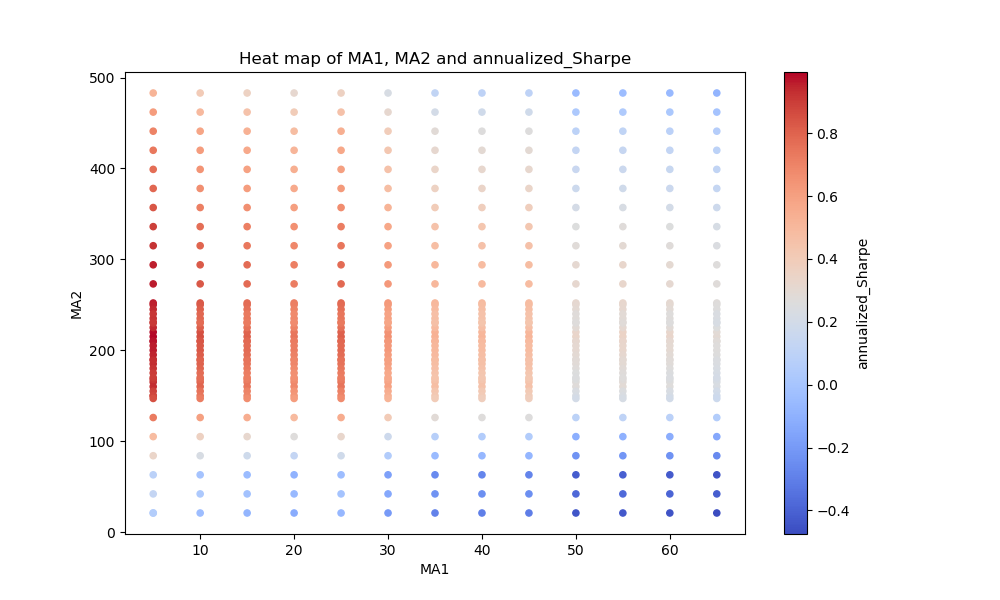

In [9]:
# Plot heat map of Sharpe ratio depending on MA1 and MA2
%matplotlib notebook
data= pd.read_csv('grid_search.csv')
data.plot.scatter(x='MA1', y ='MA2', c='annualized_Sharpe',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Heat map of MA1, MA2 and annualized_Sharpe')   
# plt.scatter(x=b['MA1'], y =b['MA2'], s=b['annualized_Sharpe']*100)
plt.show()

<IPython.core.display.Javascript object>


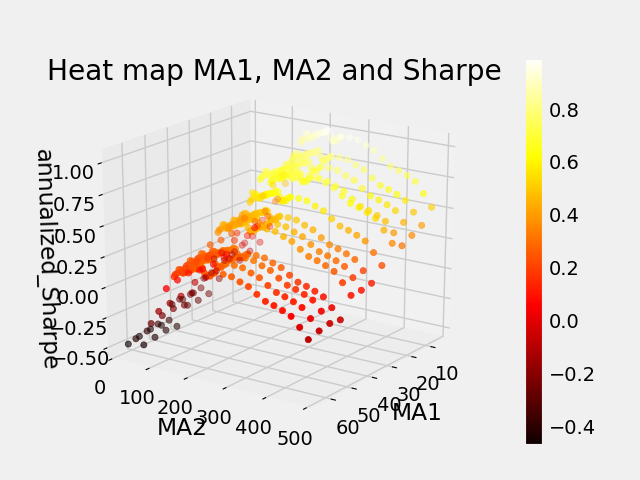

In [66]:
########## plot 3D HEat Map MA1 and MA2 
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('MA1')
ax.set_ylabel('MA2')
ax.set_zlabel('annualized_Sharpe')
ax.set_title('Heat map MA1, MA2 and Sharpe')
ax.view_init(20, 35)
z = b['annualized_Sharpe']
c = b['annualized_Sharpe']
x = b['MA1']
y = b['MA2']


img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


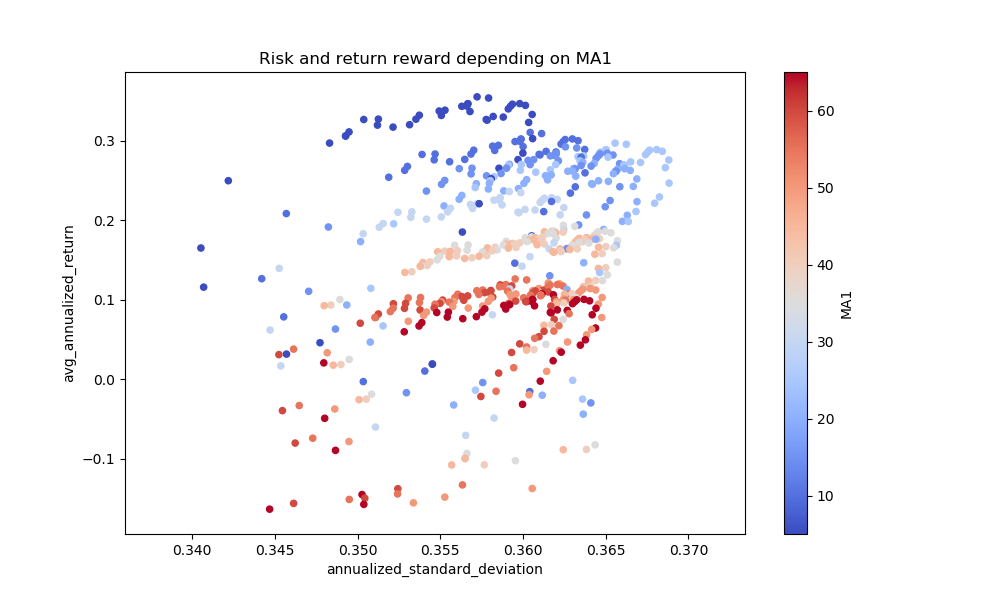

In [12]:
# How changes in MA1 and MA2 affect risk and return

b.plot.scatter(y='avg_annualized_return', x ='annualized_standard_deviation', c='MA1',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Risk and return reward depending on MA1')   
# plt.scatter(x=b['MA1'], y =b['MA2'], s=b['annualized_Sharpe']*100)
plt.show()

<IPython.core.display.Javascript object>


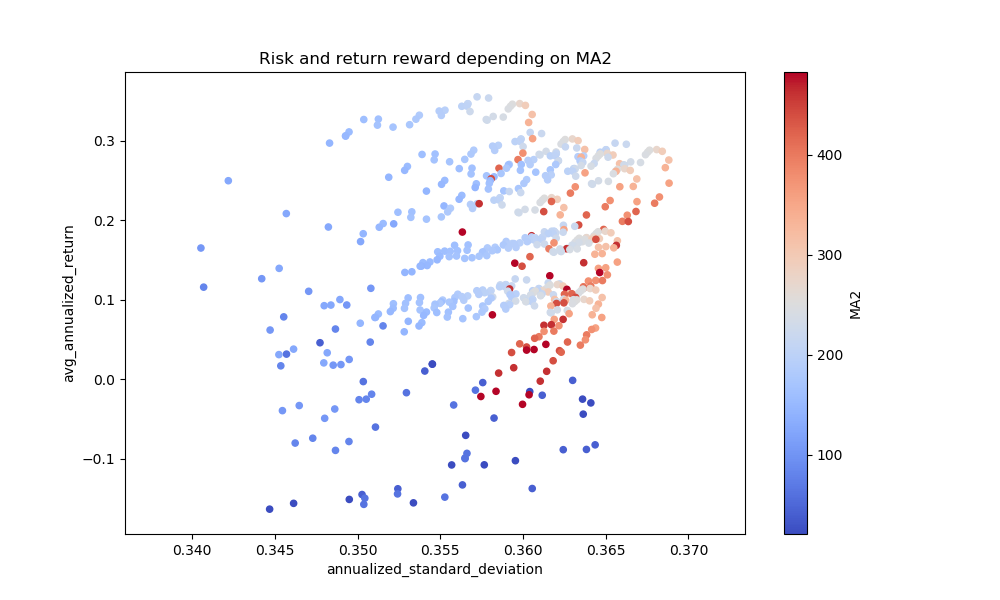

In [13]:
b.plot.scatter(y='avg_annualized_return', x ='annualized_standard_deviation', c='MA2',cmap ='coolwarm', figsize = (10,6), colorbar = True)
plt.title('Risk and return reward depending on MA2')   
# plt.scatter(x=b['MA1'], y =b['MA2'], s=b['annualized_Sharpe']*100)
plt.show()

<IPython.core.display.Javascript object>


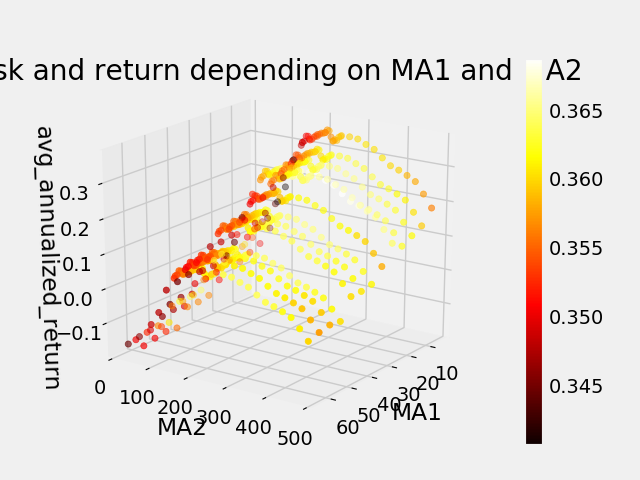

In [67]:
########## plot 3D Risk and return reward depending on MA1 and MA2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('MA1')
ax.set_ylabel('MA2')
ax.set_zlabel('avg_annualized_return')
ax.set_title('Risk and return depending on MA1 and MA2')
ax.view_init(20, 35)
z = b['avg_annualized_return']
c = b['annualized_standard_deviation']
x = b['MA1']
y = b['MA2']


img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
# For overfitting check, I run Walk Forward Analysis to see how the  strategies work out_of_sample

In [ ]:
# First I run a for loop to find an optimal training window and testing out-of-sample window

############################## FoR Loop to find optimal train and valid period ###############################
#1. Rolling window for the training set
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
ma1 = range(5, 70, 5) # ma1 =[5] ma2 = [210]
ma2 = range(21,21*15, 21) # ma2 = range(21,21*15, 21)
inputs = list(product(ma1,ma2)) 
num_cores = multiprocessing.cpu_count()
def grid_search (data1): # ma2 =range(150,252, 5)
    
    results = Parallel(n_jobs=num_cores)(delayed(future_analyzing_port_baseline)(data1,MA1,MA2) for MA1, MA2 in inputs)
    for i in range(len(results)):
        if i ==0:
            summary = results[i]
        summary = pd.concat([summary,results[i]], axis =0)
    return summary.sort_values('annualized_Sharpe', ascending = False)


df = pd.read_csv('STIR_futures_sample.csv')
df = df.drop(df.index[0:7]).reset_index().drop(columns =['index']) 
from datetime import timedelta 
col =['Time']
for i in range(1, df.shape[1],1):
    col.append(str(i))
df.columns = col # set the name for columns
df['Time'] = pd.to_datetime(df['Time'], format=('%m/%d/%Y'))

train_valid_set = df.iloc[0:df.shape[0]-252,].reset_index().drop(columns=['index']) # 
# train_valid_set = df.iloc[int(252*2.75):df.shape[0],] # test test set
test_set = df.copy()


train_valid_results = pd.DataFrame()

import time
start = time.time()
tp = [6.375]#[7, 7.5,8] # TP =7.5 VP =1
vp = [0.125]#,[0.25,0.5, 0.75,1]
for TP, VP in product(tp,vp):
    train_period = TP 
    valid_period = VP
    #if (TP == 7.5) and (VP ==0.5):
    #    continue
    number_cross_validate = ((train_valid_set['Time'][train_valid_set.shape[0]-1]-train_valid_set['Time'][0]).days-train_period*365)//(valid_period *365)
    
    train_set =[0]*int(number_cross_validate+1) 
    valid_set = [0]*int(number_cross_validate+1) 
    
    for i in range(1,int(number_cross_validate+1),1): # i=2
        print(i)
        if i ==1:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int(train_period*365)))]
        else:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int(valid_period*365*(i-1)))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((train_period+valid_period*(i-1))*365)))]
        
        valid_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int((valid_period*(i-1) + train_period-6)*365))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((valid_period*i + train_period)*365)))]

       
    training_results = []
    valid_results = []
    annualized_Sharpes = [] 
    for i in range(1, len(train_set)): # i = 1, MAX_EVALS = 3
        random_results = grid_search( data1= train_set[i])
        training_results.append(random_results)
        best_para = random_results.sort_values('annualized_Sharpe', ascending = False).head(1)
        summary_port  = future_analyzing_port_baseline(data = valid_set[i], MA1 = best_para['MA1'].iloc[0], MA2=best_para['MA2'].iloc[0])
        valid_results.append (summary_port)
        annualized_Sharpes.append(summary_port['annualized_Sharpe'].iloc[0])
        print(i)
   
    for i in range(0, len(training_results)):# i =3
    
       # training_results[i].to_csv('traning_results_walk_forward_'+str(i)+'_'+str(train_period)+'_'+str(valid_period)+'.csv', index = False)
        if i ==0:
            valid_result = valid_results[0]
        else:
            valid_result = pd.concat([valid_result,valid_results[i]], axis=0)
        
    pd.DataFrame(valid_result).to_csv('valid_results_walk_forward_'+str(i)+'_'+str(train_period)+'_'+str(valid_period)+'.csv', index = False)
    train_valid_summary = pd.DataFrame({'train_period': train_period,'valid_period': valid_period,'mean_valid_sharpe': np.mean(annualized_Sharpes)}, index=[0])
    train_valid_results = train_valid_results.append(train_valid_summary)
train_valid_results
end = time.time()
(end - start)/3600

In [ ]:
# We got the results like this: 
       train_period  valid_period  mean_valid_sharpe
 0          6.375         0.125          3.331654  
 0             7          0.125          0.112202 
 0             7          0.25           1.228202 
 0           7.5          0.25           0.277203 
 0           8.0          0.25           -0.103875 

In [ ]:
############# CASE 1 ########################################################
# From the above results I choose 1606 days (6.375*252) for training period from that we got optimal MA1 and MA2
# and then apply these MA1, MA2 into testing period of 31 days (0.125*252). The results for each period are as follows:
df = pd.read_csv('STIR_futures_sample.csv')
df = df.drop(df.index[0:7]).reset_index().drop(columns =['index']) 
from datetime import timedelta 
col =['Time']
for i in range(1, df.shape[1],1):
    col.append(str(i))
df.columns = col # set the name for columns
df['Time'] = pd.to_datetime(df['Time'], format=('%m/%d/%Y'))

train_valid_set = df
# train_valid_set = df.iloc[int(252*2.75):df.shape[0],] # test test set
test_set = df.copy()


train_valid_results = pd.DataFrame()

import time
start = time.time()
tp = [6.375]#[7, 7.5,8] # TP =7.5 VP =1
vp = [0.125]#,[0.25,0.5, 0.75,1]
for TP, VP in product(tp,vp):
    train_period = TP 
    valid_period = VP
    #if (TP == 7.5) and (VP ==0.5):
    #    continue
    number_cross_validate = ((train_valid_set['Time'][train_valid_set.shape[0]-1]-train_valid_set['Time'][0]).days-train_period*365)//(valid_period *365)
    
    train_set =[0]*int(number_cross_validate+1) 
    valid_set = [0]*int(number_cross_validate+1) 
    
    for i in range(1,int(number_cross_validate+1),1): # i=2
        
        if i ==1:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int(train_period*365)))]
        else:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int(valid_period*365*(i-1)))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((train_period+valid_period*(i-1))*365)))]
        
        valid_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int((valid_period*(i-1) + train_period-6)*365))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((valid_period*i + train_period)*365)))]

    
    from itertools import product
    from joblib import Parallel, delayed
    import multiprocessing
    num_cores = multiprocessing.cpu_count()
    valid_results = []
    annualized_Sharpes = [] 
    i_set = range(1,int(number_cross_validate+1),1)
    ma1 = list(valid_result['MA1'])
    ma2 = list(valid_result['MA2'])
    #ma1 = [5,25,60,60,20, 30, 30, 5,15,25,30,65,65,35, 20, 60, 30, 25, 60,15, 65,50,5,35,35,35,5,5,5]#6.375 - 0.125 update
    #ma2 = [273,210,210,252,210,42,273,294,252,252,252,295,294, 147, 63, 105,84,84,42,105,105,105,21,147,147,147,294,126,147]
    
    inputs = zip(i_set, ma1, ma2)
    results = Parallel(n_jobs=num_cores)(delayed(future_analyzing_port_baseline)(valid_set[i],MA1,MA2) for i, MA1, MA2 in inputs)
    
    # CHeck performance of WFA period by period
    for i in range(len(results)):# i =3
        
       # training_results[i].to_csv('traning_results_walk_forward_'+str(i)+'_'+str(train_period)+'_'+str(valid_period)+'.csv', index = False)
        if i ==0:
            valid_result = results[0]
        else:
            valid_result = pd.concat([valid_result, results[i]], axis=0)
 

In [96]:
# Add index into valid_result to know how many times we have iterated and show it
cols = valid_result .columns.tolist()
cols = cols[-1:] + cols[:-1]
valid_result  = valid_result [cols]
valid_result 

,index,Start,Finish,MA1,MA2,annualized_return,annualized_sd,annualized_Sharpe,max_draw_down,winning_percentage
0,1,2015-05-12,2015-06-29,5,273,1.205105,0.496489,2.427253,0.098972,0.588235
0,2,2015-06-26,2015-08-14,25,210,-0.517570,0.686469,-0.753960,0.193396,0.428571
0,3,2015-08-11,2015-09-28,60,210,6.778134,0.697462,9.718281,0.132557,0.500000
0,4,2015-09-25,2015-11-13,60,252,-0.190740,0.658533,-0.289643,0.259746,0.500000
0,5,2015-11-10,2015-12-29,20,210,-0.473486,0.511561,-0.925570,0.184890,0.441176
0,6,2015-12-28,2016-02-12,30,42,33.056746,0.655367,50.440041,0.097649,0.636364
0,7,2016-02-09,2016-03-29,30,273,-0.653102,0.712658,-0.916431,0.325741,0.470588
0,8,2016-03-29,2016-05-13,5,294,0.745190,0.506713,1.470635,0.195182,0.470588
0,9,2016-05-11,2016-06-28,15,252,1.432937,0.704742,2.033278,0.198417,0.500000
0,10,2016-06-28,2016-08-12,25,252,-0.789390,0.573439,-1.376590,0.246269,0.424242


In [99]:
######  Calculate return for the whole test period
df = pd.read_csv('STIR_futures_sample.csv')
df = df.drop(df.index[0:7]).reset_index().drop(columns =['index']) 
from datetime import timedelta 
col =['Time']
for i in range(1, df.shape[1],1):
    col.append(str(i))
df.columns = col # set the name for columns
df['Time'] = pd.to_datetime(df['Time'], format=('%m/%d/%Y'))

train_valid_set = df
# train_valid_set = df.iloc[int(252*2.75):df.shape[0],] # test test set
test_set = df.copy()


train_valid_results = pd.DataFrame()

import time
start = time.time()
tp = [6.375]#[7, 7.5,8] # TP =7.5 VP =1
vp = [0.125]#,[0.25,0.5, 0.75,1]
for TP, VP in product(tp,vp):
    train_period = TP 
    valid_period = VP
    #if (TP == 7.5) and (VP ==0.5):
    #    continue
    number_cross_validate = ((train_valid_set['Time'][train_valid_set.shape[0]-1]-train_valid_set['Time'][0]).days-train_period*365)//(valid_period *365)
    
    train_set =[0]*int(number_cross_validate+1) 
    valid_set = [0]*int(number_cross_validate+1) 
    
    for i in range(1,int(number_cross_validate+1),1): # i=2
        print(i)
        if i ==1:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int(train_period*365)))]
        else:
            train_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int(valid_period*365*(i-1)))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((train_period+valid_period*(i-1))*365)))]
        
        valid_set[i] = train_valid_set.loc[(train_valid_set['Time']>train_valid_set['Time'][0]+timedelta(int((valid_period*(i-1) + train_period-6)*365))) & (train_valid_set['Time']<train_valid_set['Time'][0]+timedelta(int((valid_period*i + train_period)*365)))]

    
    from itertools import product
    from joblib import Parallel, delayed
    import multiprocessing
    num_cores = multiprocessing.cpu_count()
    valid_results = []
    annualized_Sharpes = [] 
    i_set = range(1,int(number_cross_validate+1),1)
    ma1 = list(valid_result['MA1'])
    ma2 = list(valid_result['MA2'])
    #ma1 = [5,25,60,60,20, 30, 30, 5,15,25,30,65,65,35, 20, 60, 30, 25, 60,15, 65,50,5,35,35,35,5,5,5]#6.375 - 0.125 update
    #ma2 = [273,210,210,252,210,42,273,294,252,252,252,295,294, 147, 63, 105,84,84,42,105,105,105,21,147,147,147,294,126,147]

    inputs = zip(i_set, ma1, ma2)
    results = Parallel(n_jobs=num_cores)(delayed(future_analyzing_port_baseline)(valid_set[i],MA1,MA2) for i, MA1, MA2 in inputs)
    
      
    
    # CHeck performance of WFA for the whole period
    
    for i in range(len(results)): # i =1
        print(i)
        if i ==0:
            summary = results[i]
        else:
            if summary['Time'].iloc[-1] == results[i]['Time'].iloc[0]:
                summary = pd.concat([summary,results[i].iloc[1:,]], axis =0, sort=False)
            else:
                summary = pd.concat([summary,results[i]], axis =0, sort=False)
            
    summary = summary.reset_index().drop(columns = ['index'])

summary = summary[['Time','Total Ret']].drop_duplicates(subset='Time', keep='last')


summary['Cummulative return'] = np.array((1+summary['Total Ret']).cumprod() -1)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [107]:
# Cummulative return 
summary.set_index('Time', inplace = True)
avg_annualized_return_port = (1+summary['Cummulative return'].iloc[-1])**(252/summary['Cummulative return'].shape[0])-1
print('Average annualized daily return of porfolio is', round(avg_annualized_return_port*100,2),'%')
# standard deviation
annualized_standard_deviation = summary['Total Ret'].std()*np.sqrt(252)
print('Annualized standard deviation return of portfolio is', round(annualized_standard_deviation,2)*100, '%')
# sharpe ratio
annualized_Sharpe = avg_annualized_return_port/annualized_standard_deviation
print('Annualized Sharpe of portfolio is', round(annualized_Sharpe,4))
# Max drawdown
max_draw_down_port = max(-drawdown(summary['Total Ret'])) 
print('Max drawdown of portfolio is', round(max_draw_down_port,2)*100, '%')

Average annualized daily return of porfolio is 36.56 %
Annualized standard deviation return of portfolio is 47.0 %
Annualized Sharpe of portfolio is 0.7774
Max drawdown of portfolio is 39.0 %


<IPython.core.display.Javascript object>


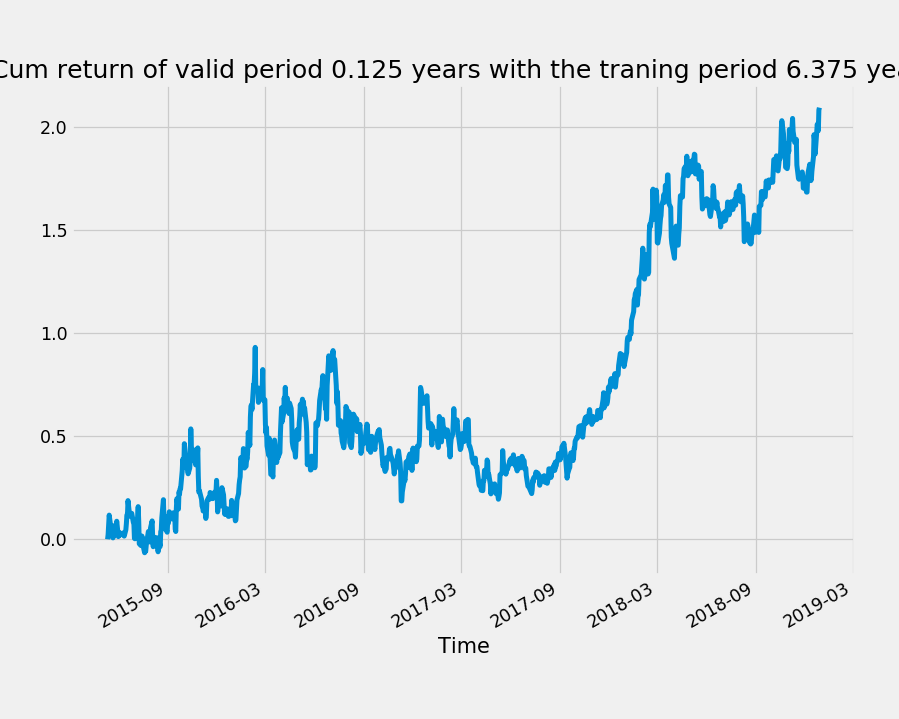

In [109]:
%matplotlib notebook
summary['Cummulative return'].plot(figsize=(10,8))
plt.title('Cum return of valid period '+ str(valid_period) + " years with the traning period " + str(train_period) + " years")
plt.show()

<IPython.core.display.Javascript object>


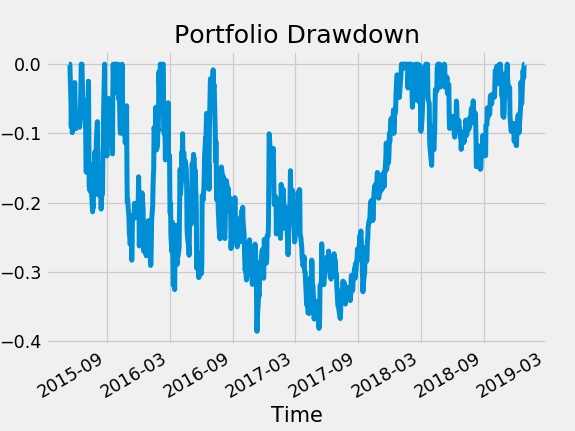

In [110]:
# Exhibit 8 : Portfolio drawdown overtime. 
%matplotlib notebook
import matplotlib.pyplot as plt 
drawdown(summary['Total Ret']).plot() 
plt.title('Portfolio Drawdown') 
plt.xlabel('Time') 
plt.ylabel('Drawdown') 
plt.show()

In [111]:
# Out of sample performance summary 
port_return =pd.DataFrame(summary['Total Ret']) 
port_return.index = pd.to_datetime(port_return.index) 
port_return['Year'] = port_return.index.year
ret1 = [] 
vol1 =[] 
sharpe1=[] 
sortino1=[] 
max_drawdown1=[] 
year1 = [] 
for year in list(np.unique(port_return['Year'])): # year = 2014    
    return_year = port_return[port_return['Year']==year]    
    return_year['Cummulative return'] = (1+return_year['Total Ret']).cumprod() -1     
    a_ret = (1+return_year['Cummulative return'].iloc[-1])**(252/return_year['Cummulative return'].shape[0])-1 # annualize    
    ret1.append(a_ret)    
    a_vol = return_year['Total Ret'].std()*252**0.5    
    vol1.append(a_vol) #252**0.5*sharpe    
    sharpe1.append(a_ret/a_vol)    
    max_drawdown1.append(max(-drawdown(return_year['Total Ret'])))    
    year1.append(year)    
    # Need a short rate to calculate the sortino 
exhibit_6 = pd.DataFrame(list(zip(year1,ret1, vol1,sharpe1, max_drawdown1)),
                        columns =['Year','Annualize_return','Annualize_volatility','Annualize_sharpe', 'MaxDrawdown']) 
exhibit_6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Year,Annualize_return,Annualize_volatility,Annualize_sharpe,MaxDrawdown
0,2015,0.237705,0.609526,0.389983,0.283233
1,2016,0.341594,0.574650,0.594437,0.385868
2,2017,0.195010,0.370295,0.526634,0.269274
3,2018,0.697870,0.315292,2.213411,0.151955


<IPython.core.display.Javascript object>


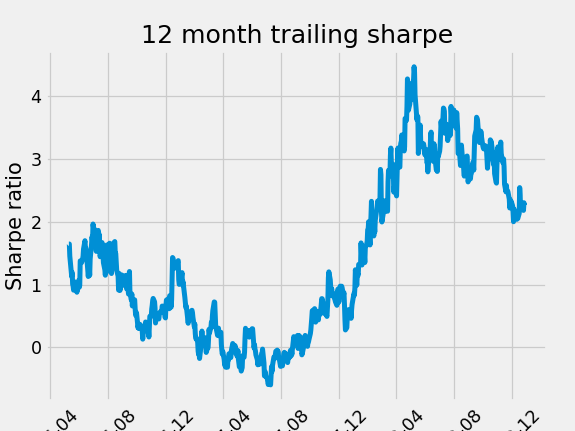

In [112]:
 # Exhibit 7: 12 month trailing sharpe 
port_return['12M_Sharpe'] = (((1+port_return['Total Ret'].rolling(252).mean())**252)-1)/(port_return['Total Ret'].rolling(252).std()*252**0.5)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(port_return['12M_Sharpe']) 
plt.xticks(rotation=45) 
plt.xlabel('Time') 
plt.ylabel('Sharpe ratio') 
plt.title('12 month trailing sharpe') 
plt.show()